# Updates after discussion

* TODO:
    * Clean this section and save comments for report
    * clear doubts about network. Give credit to blog posts whenever choices are not clear
    

* cleaning the 5% least frequent symbols from the vocab was a disaster since several steps can't handle unknown words. It's not impossible to fix this, but for the time being it's easier to work with the full corpus (~115k sentences instead of ~20k) and assume that this will make the weird symbols/words waaay less likely to appear. It's not an unfounded assumption (denke ich).

* still doesn't support unknown words

* careful when using vocab size for inference since we didn't take care of weird symbols in corpus. They might affect it a lot.

* when expanding the input_words set I won't include antonyms. I think syn, hyper and hyponyms are enough, and an incorrectly used antonym is riskier.

* should we also leave out hyponyms?

* top 3 seeds by freq of appearance in the corpus "is" >> "means" >> "can be found"

* if part i of the sentence is already covered (includes one of the input words), any part i+1 will take part i into account while generating. Doesn't sound exciting but it is a smart feature :P

* Now running on all trigrams



# Generating our descriptive sentences

## Importing everything we will need

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import random
import string
import torch
import pickle
import torch.nn as nn
#is this the best choice of autograd?
from torch.autograd import Variable 
import math
import time
import gs_probdist as gspd
import semrel as sr
import gensim
import cardgen as cg #modified version that only returns the set of MW and TWs, not the nice drawing

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

## Getting our text input

In [3]:
#opening and reading the corpus
#we will be using the full version of the descriptive corpus we made ~115k sentences
f = open('description-corpus-115k.txt', 'r')
#text = f.read()
text = f.readlines() #if we want a list with sentences as elements
f.close()

# getting lower case and splitting it
sentences = [text[i].lower().split() for i in range(len(text))]

#getting the avg length of a descriptive sentence
lengths = [len(sent) for sent in sentences]
avg_sent_length = sum(lengths)/len(lengths) # ~27

## Cleaning (NOT USED)
* Removing stop words, punctuation symbols and lemmatizing

In [ ]:
# found that in some tutorials they do 3 extra cleaning steps before applying N-grams

# getting rid of stop words
#stop_words = set(nltk.corpus.stopwords.words('english'))
#stop_free = ' '.join([word for word in text.split() if word not in stop_words])
# justification --> it's like getting rid of the long tail in the word frequency plot. Oder?

# getting rid of punctuation
#punctuation_symbols = set(string.punctuation)
#punct_free = "".join(word for word in stop_free if word not in punctuation_symbols)
# makes sense.. I think

# lemmatizing?
#lemma = nltk.stem.wordnet.WordNetLemmatizer()
#normalized = ' '.join(lemma.lemmatize(word) for word in punct_free.split())
#if it is what I think it is, then it makes sense too

#last step, lower case and splitting
#cleaned_text = normalized.lower().split()

In [ ]:
text[:250]

In [ ]:
stop_free[:250]

In [ ]:
punct_free[:250]

In [ ]:
normalized[:250]

## Implementing trigrams and setting up

In [ ]:
#creating trigram sets EASY WAY
#trigrams = [([cleaned_text[i], cleaned_text[i+1]], cleaned_text[i+2])for i in range(len(cleaned_text) - 2)]

# better way: sentence by sentence, not the whole text in one go
# this structure allows us to create context/target sets for each word. 
trigrams = []
for sentence in sentences:
    trigrams += [([sentence[i], sentence[i+1]], sentence[i+2]) for i in range(len(sentence) - 2)]

trigrams[0]
#context for target word 'text' --> 'a' and 'cookie'

len(trigrams)

#using all trigrams led to kernel death every time
# we will randomly sample 100000 of them
trigrams = random.sample(trigrams, 50000)

# getting set of words in vocab, it's length and the frequency of each word
# our vocab consists of the words appearing in trigrams, so no need to take the vocab over the whole text
# if we are not using all trigrams
voc = set()
for tri in trigrams:
    voc = voc.union(set(np.union1d(np.array(tri[0]), np.asarray(tri[1]))))
voc_length = len(voc) #34174
word_to_freq = {word: i for i, word in enumerate(voc)}

voc_length

#the detected some errors on how our corpus is tokenized ("binoculars" is imported as bi - no -cu-lars) we will remove the 5% less frequent found words in the dictionary.
# THIS AFFECTED THE CELL BELOW. INSTEAD OF USING THIS CODE TO CLEAN THE POSSIBLE OUTPUTS WE WILL ASSUME THAT USING OUR BIGGER VERSION OF THE CORPUS SHOULD MINIMIZE 
# THE LIKELIHOOD OF FINDING THESE WEIRD TOKENS DURING THE GENERATION STEP


# freq values from dictionary to array
#freq_values = np.array([v for k, v in word_to_freq.items()])
#np.percentile(freq_values, 5) # ~1709

#getting rid of those unusual values
# creating list of keys to delete
#to_del = [k for k, v in word_to_freq.items() if v < 1709]

# deleting those elements from the word_to_freq dict
#for k in to_del: del word_to_freq[k]

#creating lists where we will store the input tensors
cont = []
tar = []
for context, target in trigrams:
    #creates a tensor with the frequency of both current context words
    context_freqs = torch.tensor([word_to_freq[word] for word in context], dtype = torch.long)
    #adds the tensor to inp
    cont.append(context_freqs)
    # does the same for the target and its frequency
    target_freq = torch.tensor([word_to_freq[target]], dtype = torch.long)
    tar.append(target_freq)

## Building the network 

In [13]:
#Cheking if we have access to training on GPU
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Fancy setup!')
else: 
    print('Too bad, training on CPU; dont exagerate with number of epochs.')

my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Too bad, training on CPU; dont exagerate with number of epochs.


In [14]:
class GRU(nn.Module):
    #init for input size, hidden size, output size and number of hidden layers.
    def __init__(self, input_s, hidden_s, output_s,n_layers = 1):
        super(GRU, self).__init__()
        self.input_s = input_s
        self.hidden_s = hidden_s
        self.output_s = output_s
        self.n_layers = n_layers
        # our encoder will be nn.Embedding
        # reminder: the encoder takes the input and outputs a feature tensor holding the information representing the input.
        self.encoder = nn.Embedding(input_s, hidden_s)
        #defining the GRU cell, still have to determine which parameters work best
        self.gru = nn.GRU(2*hidden_s, hidden_s, n_layers, batch_first=True, bidirectional=False)
        # defining linear decoder
        self.decoder = nn.Linear(hidden_s, output_s)
    
    def forward(self, input, hidden):
        #making sure that the input is a row vector
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1,-1))
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_s))

In [15]:
def train(context, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for t in range(len(trigrams)):
        output, hidden = decoder(context[t], hidden)
        loss += criterion(output, target[t])
        
    loss.backward()
    decoder_optimizer.step()
    
    return loss.data.item() / len(trigrams)

In [16]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [17]:
n_epochs = 100
print_every = 10
plot_every = 10
hidden_s = 150
n_layers = 1
lr = 0.015

decoder = GRU(voc_length, hidden_s, voc_length, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
for epoch in range(1, n_epochs + 1):
    loss = train(cont,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 49s (10 5%) 5.3125]
 29s (20 10%) 3.8183]
 11s (30 15%) 2.6607]
 1s (40 20%) 1.8293]
 0s (50 25%) 1.2669]
 37s (60 30%) 0.8885]
 48s (70 35%) 0.6325]
 5s (80 40%) 0.4578]
 23s (90 45%) 0.3357]
 30s (100 50%) 0.2497]


In [18]:
import os
# saving the model
# instructions found here: https://pytorch.org/tutorials/beginner/saving_loading_models.html

#saving model for inference --> save state_dict
path1 = os.getcwd()+'/test5_trained_inference.pt'

torch.save(decoder.state_dict(),path1)

#to load
# decoder = GRU(voc_length, hidden_s, voc_length, n_layers)
# decoder.load_stat_dict(torch.load(path))
# decoder.eval()

In [19]:
#saving entire model
path2 = os.getcwd()+'/test5_trained_entire.pt'
torch.save(decoder, path1)

#loading
# Model class must be defined somewhere
#decoder = torch.load(path)
#decoder.eval()

/Users/rlpa/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [21]:
#in case we forgot to set a seed for the trigram sampling step, we can save the current object with pickle
#with open("trigrams_test5.txt", "wb") as fp:
#    pickle.dump(trigrams, fp)

#with open("trigrams_test5.txt", "rb") as fp:
#   trigrams = pickle.load(fp)

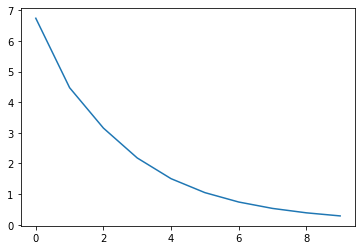

In [22]:
import matplotlib.ticker as ticker
%matplotlib inline

f= open('test5_losses.csv', 'w+')
f.write(str(all_losses)[1:-1])
f.close()
plt.figure()
plt.plot(all_losses)
plt.savefig('test_5.png')

In [23]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_freq[w] for w in prime_str.split()], dtype=torch.long)
        cont = prime_input[-2:] #last two words as input
        output, hidden = decoder(cont, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_freq.keys())[list(word_to_freq.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [24]:
print(evaluate('the main', 10, temperature = 1))

the main of the casting that going to citi familiar him next


## Generating descriptive sentence
* input = main word + taboo words

The main idea here is that we will seed always with the main word and replace at the end.
The descriptive sentence will be accepted into the cleaning step (where we will make sure that no tws or the mw were used and if so, we'll replace them) if it contains at least two of the input words, besides the seeds. As long as the sentence is not accepted, we will keep generating.

To help reach a high score: once an input word has been used and its score_vector value increases, we will leave that segment in our sentence. Not sure if this hurts more than it helps, but adding the input word as a seed is VERY complicated. And not sure it would make sense either.

For a first prototype we will assume that maximum one new word is gonna be added per iteration. 

Pretty fragile with many assumptions?

It would be useful to generate a list of synonyms of all input words to expand the input_words set and have higher acceptance rate. We thought about cleaning the input words set from the start but those are words with high probability of occurence so we better leave them and clean in the end.

* maybe more seeds?
* maybe require a higher score?
* how to properly connect end of sentences and seeds? Is it better to have fewer seeds but longer auto-generated text?
* add time it to report results and "quantify" results/improvements

### Description generator

In [25]:
def gen_input_words(mw, model):
    #mw = main word
    #model = embeddings used to generate the cards
    
    #generating the corresponding taboo card
    card_words = cg.card_generator(mw, cg.get_gold_probdist(), model)
    #set of words that we hope will appear in the description
    input_words = card_words[mw] + [mw]

    # extending the input_words set using semantic relations. Bigger set --> better chances of generating an approved word!
    # we will use the make_semrel_dict function to get synonyms, hyponyms and hypernyms of the MW.
    # we considered adding also semrel words from the tw, but the loose connection to the MW very fast
    # we will leave out antonyms as they might make they are "riskier" to use in a description.

    adds = []
    temp = sr.make_semrel_dict(mw)
    for k in temp.keys():
        if k != 'semrel_antonym':
            new = list(temp[k])
            adds += new
    adds = np.unique(adds)
    adds = [x.lower() for x in adds]
    input_words = np.unique(input_words + adds)

    # filtering out the input words that are not in our vocab. Shouldn't be a thing when using larger corpus
    input_words = [word for word in input_words if word in voc]    
    return input_words

def description_generator(mw, model, n_seeds = 3, n_iterations = 10, debugging = False, printing = False):
    #mw = main word
    #model = embeddings used to generate the cards
    #n_seeds = if we are using 2 or 3 seeds during the sentence generation step
    #n_iterations = how many iterations we will do in the generation step
    #debugging = True if we want to print some statistics about the process. False if we only want the last 5 generated sentences.
    #printing = True will print something, based on debugging. If false, it will only return the final sentence
    
    #generating the input_words we are aiming to include in our description
    input_words = gen_input_words(mw, model)    
    #on average a descriptive sentence had 27 words/symbols.
    # we will equally divide them between our seeds
    
    
    # iterate until nice sentence comes up
    # we will add safety measure to not break everything
    i = 0
    index_in_sentence = -1
    
    
    #if we are using 3 seeds
    #the 3 most frequent ones in our corpus were "x is", 'x means' and "x can be found"
    if n_seeds == 3:
        #create the first sentence
        sentence_parts = np.array([evaluate(mw+' means', 7, temperature = 1), evaluate(mw+' is', 7, temperature = 1), evaluate(mw+' can be found', 5, temperature = 1)])
        sentence =  " ".join(sentence_parts)
        eval_sentence = sentence.split()   
    
        # to keep track of scores
        scores = np.zeros(n_iterations)
        #first score vector and score
        #and accounting for the 3 times the TW appears already in the seeds
        score_vector = np.array([eval_sentence.count(word) for word in input_words])
        score_vector[input_words.index(mw)] -= 3 
        score = np.sum(score_vector)  

        # the covered vector will take care that we don't replace a segment that we already "like"
        covered = np.array([0,0,0])
        changes = np.zeros(len(score_vector))

        #known positions of input words in our sentence
        positions = np.zeros(len(eval_sentence))

        #we know the positions of the seeds
        positions[0] = 1
        positions[9] = 1
        positions[18] = 1
        
        while i < n_iterations:
            #aware that with this flow we are doing one iteration after reaching the desired score, but it's no big deal because score is designed to only go up.

            #checking if score improved
            new_score_vector = np.array([eval_sentence.count(word) for word in input_words])
            new_score_vector[input_words.index(mw)] -= 3 
            changes = new_score_vector - score_vector

            if True in (changes>0): #there was a change. Assuming there is max 1 change per iteration from now on
                index = np.where(changes == 1)[0][0] #looking for the position in which an input_word was added
                word_that_was_added = input_words[index] #if we stop assuming that, here we have to keep track of location and magnitude of changes
                
                #finding in which segment that new added word is in order to leave the segment untouched

                #this detects the index of the word that just came up in case that word was already in our sentence
                indices_in_sentence = np.where(np.array(eval_sentence) == word_that_was_added)[0]
                if len(indices_in_sentence) >1: #word appears at least twice
                    for d in indices_in_sentence:
                        if positions[d] != 1:
                            index_in_sentence = d
                            positions[d] = 1
                else:
                    index_in_sentence = indices_in_sentence[0]
                    positions[index_in_sentence] = 1
                #keeping the segment in which the improvement took place
                if index_in_sentence in range(9) & covered[0]!=1:
                    sentence_parts[1] = evaluate(mw+' is', 7, temperature = 1)
                    sentence_parts[2] = evaluate(mw+' can be found', 5, temperature = 1)
                    sentence = ' '.join(sentence_parts)
                    covered[0] = 1
                elif index_in_sentence in range(9, 18) & covered[1] !=1:
                    sentence_parts[0] = evaluate(mw+' means', 7, temperature = 1)
                    sentence_parts[2] = evaluate(mw+' can be found', 5, temperature = 1)
                    sentence = ' '.join(sentence_parts)
                    covered[1] = 1
                elif index_in_sentence in range(18, 27) & covered[2] != 1:
                    sentence_parts[1] = evaluate(mw+' is', 7, temperature = 1)
                    sentence_parts[0] = evaluate(mw+' means', 7, temperature = 1)
                    sentence = ' '.join(sentence_parts)
                    covered[2] = 1
                eval_sentence = sentence.split()
                changes = np.zeros(len(score_vector))
                index_in_sentence = 0
                score_vector = new_score_vector
                score = np.sum(score_vector)

            #if there was no change
            else: #based on what is already covered
                if covered[0] ==0:
                    sentence_parts[0] = evaluate(mw+' means', 7, temperature = 1) +' '
                #if the first part is already covered we can add it as input to generate the second
                if covered[1] ==0:
                    if covered[0]==1:
                        temp =  evaluate(sentence_parts[0]+' '+ mw+' is', 7, temperature = 1) +' '
                        #taking off the first part from it
                        temp = temp.split()
                        sentence_parts[1] = " ".join(temp[9:])   
                    else:
                        sentence_parts[1] = evaluate(mw+' is', 7, temperature = 1) +' '
                # same logic for the third part.
                if covered[2] == 0:
                    if covered[1] == 0:
                        sentence_parts[2] = evaluate(mw+' can be found', 5, temperature = 1)
                    else:
                        temp =  evaluate(sentence_parts[1]+' '+ mw+' can be found', 5, temperature = 1) +' '
                        #taking off the second part from it
                        temp = temp.split()
                        sentence_parts[2] = " ".join(temp[9:])
                sentence = ' '.join(sentence_parts)
                eval_sentence = sentence.split()
                score_vector = new_score_vector
                score = np.sum(score_vector)
            if printing == True:
                if debugging ==True:
                    print("Sentence number: " + str(i+1))
                    print(sentence)
                    if True in (changes>0):
                        print(changes)
                    print(covered)
                    print(positions)
                else:
                    if i in range(n_iterations-5, n_iterations):
                        print(sentence)
            scores[i] = score
            i +=1
            
    #if we are using 2 seeds
    #the 2 most frequent ones in our corpus were "x is" and 'x means'
    if n_seeds == 2:
        #create the first sentence
        sentence_parts = np.array([evaluate(mw+' means', 11, temperature = 1), evaluate(mw+' is', 12, temperature = 1)])
        sentence =  " ".join(sentence_parts)
        eval_sentence = sentence.split()   
    
        # to keep track of scores
        scores = np.zeros(n_iterations)
        #first score vector and score
        #and accounting for the 3 times the TW appears already in the seeds
        score_vector = np.array([eval_sentence.count(word) for word in input_words])
        score_vector[input_words.index(mw)] -= 3 
        score = np.sum(score_vector)  

        # the covered vector will take care that we don't replace a segment that we already "like"
        covered = np.array([0,0])
        changes = np.zeros(len(score_vector))

        #known positions of input words in our sentence
        positions = np.zeros(len(eval_sentence))

        #we know the positions of the seeds
        positions[0] = 1
        positions[14] = 1
        
        while i < n_iterations:
            #aware that with this flow we are doing one iteration after reaching the desired score, but it's no big deal because score is designed to only go up.

            #checking if score improved
            new_score_vector = np.array([eval_sentence.count(word) for word in input_words])
            new_score_vector[input_words.index(mw)] -= 3 
            changes = new_score_vector - score_vector

            if True in (changes>0): #there was a change. Assuming there is max 1 change per iteration from now on
                index = np.where(changes == 1)[0][0] #looking for the position in which an input_word was added
                word_that_was_added = input_words[index] #if we stop assuming that, here we have to keep track of location and magnitude of changes
                
                #finding in which segment that new added word is in order to leave the segment untouched

                #this detects the index of the word that just came up in case that word was already in our sentence
                indices_in_sentence = np.where(np.array(eval_sentence) == word_that_was_added)[0]
                if len(indices_in_sentence) >1: #word appears at least twice
                    for d in indices_in_sentence:
                        if positions[d] != 1:
                            index_in_sentence = d
                            positions[d] = 1
                else:
                    index_in_sentence = indices_in_sentence[0]
                    positions[index_in_sentence] = 1
                #keeping the segment in which the improvement took place
                if index_in_sentence in range(14):
                    sentence_parts[1] = evaluate(mw+' is', 12, temperature = 1)
                    sentence = ' '.join(sentence_parts)
                    covered[0] = 1
                elif index_in_sentence in range(14, 27):
                    sentence_parts[0] = evaluate(mw+' means', 11, temperature = 1)
                    sentence = ' '.join(sentence_parts)
                    covered[1] = 1
                eval_sentence = sentence.split()
                changes = np.zeros(len(score_vector))
                index_in_sentence = 0
                score_vector = new_score_vector
                score = np.sum(score_vector)

            #if there was no change
            else: #based on what is already covered
                if covered[0] ==0:
                    sentence_parts[0] = evaluate(mw+' means', 11, temperature = 1) +' '
                #if the first part is already covered we can add it as input to generate the second
                if covered[1] ==0:
                    if covered[0]==1:
                        temp =  evaluate(sentence_parts[0]+' '+ mw+' is', 12, temperature = 1) +' '
                        #taking off the first part from it
                        temp = temp.split()
                        sentence_parts[1] = " ".join(temp[12:])   
                    else:
                        sentence_parts[1] = evaluate(mw+' is', 7, temperature = 1) +' '
                sentence = ' '.join(sentence_parts)
                eval_sentence = sentence.split()
                score_vector = new_score_vector
                score = np.sum(score_vector)
            
            if printing == True:
                if debugging ==True:
                    print("Sentence number: " + str(i+1))
                    print(sentence)
                    if True in (changes>0):
                        print(changes)
                    print(covered)
                    print(positions)
                else:
                    if i in range(n_iterations-5, n_iterations):
                        print(sentence)
            scores[i] = score
            i +=1
    return sentence

In [ ]:
#description_generator('cake', model, n_seeds = 3, n_iterations = 2, debugging = False, printing = True)

### Cleaning the generated sentence


In [26]:
def sentence_cleaner(sentence, mw, model):
    #replacing MW with "the main word" and TWs appearing in the sentence with one of their synonyms
    sentence = sentence.replace(mw, 'The main word')
    
    #replacing any TWs appearing in our sentence with some allowed synonym
    taboo_words = cg.card_generator(mw, cg.get_gold_probdist(), model)[mw]

    spl = np.array(sentence.split())
    for tw in taboo_words:
        if tw in spl:
           #getting synonyms of detected tw
            syns = sr.get_synonyms(tw)
            if len(syns) > 0:
                syns = list(syns)
                choice = np.random.choice(syns)
                sentence = sentence.replace(tw, choice)
    return sentence

### Final output

In [27]:
def final_output(mw, model, n_seeds = 3, n_iterations = 10, debugging = False, printing = False):
    sentence = description_generator(mw, model, n_seeds, n_iterations, debugging, printing)
    output = sentence_cleaner(sentence, mw, model)
    return output

In [28]:
final_output(mw = 'cake', model = model, n_seeds=2, n_iterations = 100, debugging = True, printing = True)

Sentence number: 1
cake means indian done larger reality simply going condition - such b cake is a person in the process is an 
[0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Sentence number: 2
cake means thieves building north to determination public open anyway cake is a fact set of killings - house 
[0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Sentence number: 3
cake means $ drawing significant air army allocation weapons technolo cake is a thank is the fact that they 
[0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Sentence number: 4
cake means reward deciding or hear game . implies , an than such  cake is a term means they do not say 
[0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Sentence number: 5
cake means 5 sign player meeting not answer anywhere that would be a  cake is a list is no one who is 
[0 0]
[1. 

'The main word means positively reading sale evidence , an or reaction class th The main word is a number , a dish is a '